In [1]:
x=1

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [4]:
light_cmap = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.YlGnBu)

In [5]:
df_type = {
    'ARI': 'Bio conservation',
    'NMI': 'Bio conservation',
    'Label ASW': 'Bio conservation',
    'Isolated label ASW': 'Bio conservation',
    'Batch ASW': 'Batch correction',
    'Graph Connectivity': 'Batch correction',
    'Bio conservation': 'Aggregate score',
    'Batch correction': 'Aggregate score',
    'Total': 'Aggregate score',
}
df_type = pd.DataFrame(df_type, index=['Metric Type'])
df_type

,ARI,NMI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


# Hao

In [6]:
df_mofa = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/MOFA+/hao_mofa_new.csv', index_col=0, header=0)
df_mofa = df_mofa.dropna()
df_mofa = df_mofa.T
df_mofa = df_mofa.rename(index={'0': 'MOFA+'})
df_mofa

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
MOFA+,0.764907,0.625097,0.58269,0.774562,0.585832,0.921138


In [7]:
df_multigrate = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/multigrate/multigrate_hao.csv', index_col=0, header=0)
df_multigrate = df_multigrate.dropna()
df_multigrate = df_multigrate.T
df_multigrate = df_multigrate.rename(index={'0': 'Multigrate'})
df_multigrate

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.841413,0.792095,0.654312,0.891315,0.644881,0.950743


In [8]:
df_totalvi = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/recomb_multimodal_q2r/data/hao/0.001_embed.csv', index_col=0, header=0)
df_totalvi = df_totalvi.dropna()
df_totalvi = df_totalvi.T
df_totalvi = df_totalvi.rename(index={'0': 'totalVI'})
df_totalvi

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
totalVI,0.818238,0.679629,0.577603,0.93607,0.598906,0.9814


In [9]:
df_wnn = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/Seuratv4/hao-seurat.csv', index_col=0, header=0)
df_wnn = df_wnn.dropna()
df_wnn = df_wnn.T
df_wnn = df_wnn.rename(index={'0': 'Seurat WNN'})
df_wnn

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Seurat WNN,0.836297,0.704605,0.571911,0.877684,0.5927,0.98399


In [10]:
df = pd.concat([df_multigrate, df_mofa, df_totalvi, df_wnn])
df

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.841413,0.792095,0.654312,0.891315,0.644881,0.950743
MOFA+,0.764907,0.625097,0.582690,0.774562,0.585832,0.921138
totalVI,0.818238,0.679629,0.577603,0.936070,0.598906,0.981400
Seurat WNN,0.836297,0.704605,0.571911,0.877684,0.592700,0.983990


In [11]:
df = df.rename(columns={
    'NMI_cluster/label': 'NMI', 
    'ARI_cluster/label': 'ARI',
    'ASW_label': 'Label ASW',
    'ASW_label/batch': 'Batch ASW',
    'isolated_label_silhouette': 'Isolated label ASW',
    'graph_conn': 'Graph Connectivity',
})

In [12]:
df.loc[:, 'Bio conservation'] = np.mean([df.loc[:, 'ARI'], df.loc[:, 'NMI'], df.loc[:, 'Isolated label ASW'], df.loc[:, 'Label ASW']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation
Multigrate,0.841413,0.792095,0.654312,0.891315,0.644881,0.950743,0.733176
MOFA+,0.764907,0.625097,0.582690,0.774562,0.585832,0.921138,0.639632
totalVI,0.818238,0.679629,0.577603,0.936070,0.598906,0.981400,0.668594
Seurat WNN,0.836297,0.704605,0.571911,0.877684,0.592700,0.983990,0.676378


In [13]:
df.loc[:, 'Batch correction'] = np.mean([df.loc[:, 'Batch ASW'], df.loc[:, 'Graph Connectivity']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction
Multigrate,0.841413,0.792095,0.654312,0.891315,0.644881,0.950743,0.733176,0.921029
MOFA+,0.764907,0.625097,0.582690,0.774562,0.585832,0.921138,0.639632,0.847850
totalVI,0.818238,0.679629,0.577603,0.936070,0.598906,0.981400,0.668594,0.958735
Seurat WNN,0.836297,0.704605,0.571911,0.877684,0.592700,0.983990,0.676378,0.930837


In [14]:
df.loc[:, 'Total'] = 0.6 * df.loc[:, 'Bio conservation'] + 0.4 * df.loc[:, 'Batch correction']

In [15]:
df = pd.concat([df, df_type])

In [16]:
score_cols = df.columns[df.loc['Metric Type'] == 'Aggregate score']
other_cols = df.columns[df.loc['Metric Type'] != 'Aggregate score']

In [17]:
plot_df = df.drop('Metric Type', axis=0)

In [18]:
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)

In [19]:
plot_df["Method"] = plot_df.index

In [20]:
column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

In [21]:
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.841413,0.792095,0.654312,0.891315,0.644881,0.950743,0.733176,0.921029,0.808317
MOFA+,0.764907,0.625097,0.58269,0.774562,0.585832,0.921138,0.639632,0.84785,0.722919
totalVI,0.818238,0.679629,0.577603,0.93607,0.598906,0.9814,0.668594,0.958735,0.78465
Seurat WNN,0.836297,0.704605,0.571911,0.877684,0.5927,0.98399,0.676378,0.930837,0.778162
Metric Type,Bio conservation,Bio conservation,Bio conservation,Batch correction,Bio conservation,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [22]:
df = df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total']]
df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.841413,0.792095,0.654312,0.644881,0.891315,0.950743,0.733176,0.921029,0.808317
MOFA+,0.764907,0.625097,0.58269,0.585832,0.774562,0.921138,0.639632,0.84785,0.722919
totalVI,0.818238,0.679629,0.577603,0.598906,0.93607,0.9814,0.668594,0.958735,0.78465
Seurat WNN,0.836297,0.704605,0.571911,0.5927,0.877684,0.98399,0.676378,0.930837,0.778162
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [23]:
plot_df = plot_df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total', 'Method']]
plot_df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total,Method
Multigrate,0.841413,0.792095,0.654312,0.644881,0.891315,0.950743,0.733176,0.921029,0.808317,Multigrate
totalVI,0.818238,0.679629,0.577603,0.598906,0.936070,0.981400,0.668594,0.958735,0.784650,totalVI
Seurat WNN,0.836297,0.704605,0.571911,0.592700,0.877684,0.983990,0.676378,0.930837,0.778162,Seurat WNN
MOFA+,0.764907,0.625097,0.582690,0.585832,0.774562,0.921138,0.639632,0.847850,0.722919,MOFA+


In [24]:
plot_df.to_csv('csv/all_metrics_hao.csv')

In [25]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

In [26]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=light_cmap, num_stds=2.5)

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": cmap_fn(plot_df[col]),
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

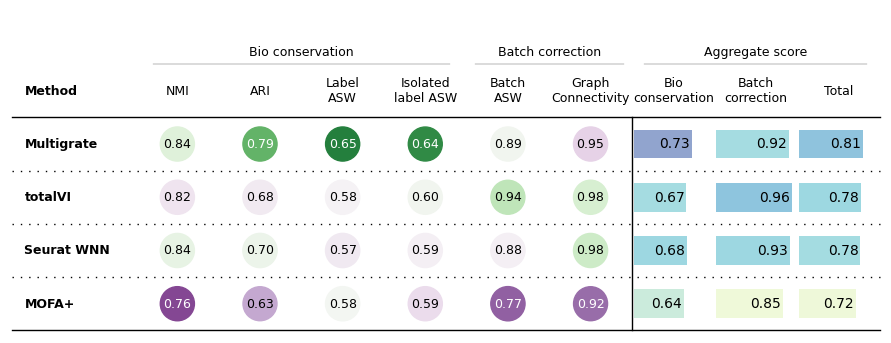

In [27]:
num_embeds = len(plot_df)

# Allow to manipulate text post-hoc (in illustrator)
with matplotlib.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 9, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col="Method",
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.savefig('figures/scib_table_hao.svg', bbox_inches='tight')

plt.show()


# neurips cite

In [28]:
df_mofa = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/MOFA+/neurips_cite_mofa_new.csv', index_col=0, header=0)
df_mofa = df_mofa.dropna()
df_mofa = df_mofa.T
df_mofa = df_mofa.rename(index={'0': 'MOFA+'})
df_mofa

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
MOFA+,0.640398,0.374594,0.570123,0.804016,0.601662,0.844645


In [29]:
df_multigrate = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/multigrate/multigrate_neurips_cite.csv', index_col=0, header=0)
df_multigrate = df_multigrate.dropna()
df_multigrate = df_multigrate.T
df_multigrate = df_multigrate.rename(index={'0': 'Multigrate'})
df_multigrate

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.79275,0.74074,0.607309,0.818657,0.643355,0.909775


In [30]:
df_totalvi = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/recomb_multimodal_q2r/data/neurips-cite/0.001_embed_leiden.csv', index_col=0, header=0)
df_totalvi = df_totalvi.dropna()
df_totalvi = df_totalvi.T
df_totalvi = df_totalvi.rename(index={'0': 'totalVI'})
df_totalvi

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
totalVI,0.800939,0.758088,0.570132,0.889003,0.624951,0.929448


In [31]:
df_wnn = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/Seuratv4/neurips-cite-seurat.csv', index_col=0, header=0)
df_wnn = df_wnn.dropna()
df_wnn = df_wnn.T
df_wnn = df_wnn.rename(index={'0': 'Seurat WNN'})
df_wnn

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Seurat WNN,0.759189,0.655493,0.573505,0.798508,0.490371,0.915899


In [32]:
df = pd.concat([df_multigrate, df_mofa, df_totalvi, df_wnn])
df

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.792750,0.740740,0.607309,0.818657,0.643355,0.909775
MOFA+,0.640398,0.374594,0.570123,0.804016,0.601662,0.844645
totalVI,0.800939,0.758088,0.570132,0.889003,0.624951,0.929448
Seurat WNN,0.759189,0.655493,0.573505,0.798508,0.490371,0.915899


In [33]:
df = df.rename(columns={
    'NMI_cluster/label': 'NMI', 
    'ARI_cluster/label': 'ARI',
    'ASW_label': 'Label ASW',
    'ASW_label/batch': 'Batch ASW',
    'isolated_label_silhouette': 'Isolated label ASW',
    'graph_conn': 'Graph Connectivity',
})

In [34]:
df.loc[:, 'Bio conservation'] = np.mean([df.loc[:, 'ARI'], df.loc[:, 'NMI'], df.loc[:, 'Isolated label ASW'], df.loc[:, 'Label ASW']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation
Multigrate,0.792750,0.740740,0.607309,0.818657,0.643355,0.909775,0.696039
MOFA+,0.640398,0.374594,0.570123,0.804016,0.601662,0.844645,0.546694
totalVI,0.800939,0.758088,0.570132,0.889003,0.624951,0.929448,0.688528
Seurat WNN,0.759189,0.655493,0.573505,0.798508,0.490371,0.915899,0.619639


In [35]:
df.loc[:, 'Batch correction'] = np.mean([df.loc[:, 'Batch ASW'], df.loc[:, 'Graph Connectivity']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction
Multigrate,0.792750,0.740740,0.607309,0.818657,0.643355,0.909775,0.696039,0.864216
MOFA+,0.640398,0.374594,0.570123,0.804016,0.601662,0.844645,0.546694,0.824331
totalVI,0.800939,0.758088,0.570132,0.889003,0.624951,0.929448,0.688528,0.909225
Seurat WNN,0.759189,0.655493,0.573505,0.798508,0.490371,0.915899,0.619639,0.857204


In [36]:
df.loc[:, 'Total'] = 0.6 * df.loc[:, 'Bio conservation'] + 0.4 * df.loc[:, 'Batch correction']

In [37]:
df = pd.concat([df, df_type])

In [38]:
score_cols = df.columns[df.loc['Metric Type'] == 'Aggregate score']
other_cols = df.columns[df.loc['Metric Type'] != 'Aggregate score']

In [39]:
plot_df = df.drop('Metric Type', axis=0)

In [40]:
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)

In [41]:
plot_df["Method"] = plot_df.index

In [42]:
column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

In [43]:
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.79275,0.74074,0.607309,0.818657,0.643355,0.909775,0.696039,0.864216,0.763309
MOFA+,0.640398,0.374594,0.570123,0.804016,0.601662,0.844645,0.546694,0.824331,0.657749
totalVI,0.800939,0.758088,0.570132,0.889003,0.624951,0.929448,0.688528,0.909225,0.776807
Seurat WNN,0.759189,0.655493,0.573505,0.798508,0.490371,0.915899,0.619639,0.857204,0.714665
Metric Type,Bio conservation,Bio conservation,Bio conservation,Batch correction,Bio conservation,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [44]:
df = df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total']]
df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.79275,0.74074,0.607309,0.643355,0.818657,0.909775,0.696039,0.864216,0.763309
MOFA+,0.640398,0.374594,0.570123,0.601662,0.804016,0.844645,0.546694,0.824331,0.657749
totalVI,0.800939,0.758088,0.570132,0.624951,0.889003,0.929448,0.688528,0.909225,0.776807
Seurat WNN,0.759189,0.655493,0.573505,0.490371,0.798508,0.915899,0.619639,0.857204,0.714665
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [45]:
plot_df = plot_df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total', 'Method']]
plot_df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total,Method
totalVI,0.800939,0.758088,0.570132,0.624951,0.889003,0.929448,0.688528,0.909225,0.776807,totalVI
Multigrate,0.792750,0.740740,0.607309,0.643355,0.818657,0.909775,0.696039,0.864216,0.763309,Multigrate
Seurat WNN,0.759189,0.655493,0.573505,0.490371,0.798508,0.915899,0.619639,0.857204,0.714665,Seurat WNN
MOFA+,0.640398,0.374594,0.570123,0.601662,0.804016,0.844645,0.546694,0.824331,0.657749,MOFA+


In [46]:
plot_df.to_csv('csv/all_metrics_neurips_cite.csv')

In [47]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

In [48]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=light_cmap, num_stds=2.5)

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": cmap_fn(plot_df[col]),
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

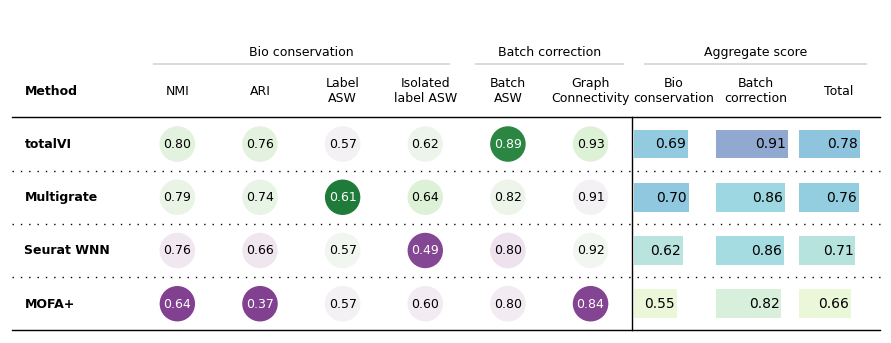

In [49]:
num_embeds = len(plot_df)

# Allow to manipulate text post-hoc (in illustrator)
with matplotlib.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 9, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col="Method",
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.savefig('figures/scib_table_neurips_cite.svg', bbox_inches='tight')

plt.show()


# neurips multiome

In [50]:
df_mofa = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/MOFA+/neurips_multiome_mofa_new.csv', index_col=0, header=0)
df_mofa = df_mofa.dropna()
df_mofa = df_mofa.T
df_mofa = df_mofa.rename(index={'0': 'MOFA+'})
df_mofa

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
MOFA+,0.606385,0.258605,0.534082,0.813457,0.604399,0.923153


In [51]:
df_multigrate = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/multigrate/multigrate_neurips_multiome_new_cpm.csv', index_col=0, header=0)
df_multigrate = df_multigrate.dropna()
df_multigrate = df_multigrate.T
df_multigrate = df_multigrate.rename(index={'0': 'Multigrate'})
df_multigrate

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.784768,0.73276,0.593101,0.852988,0.673258,0.960074


In [52]:
df_totalvi = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/recomb_multimodal_q2r/data/neurips-multiome/0.001_embed.csv', index_col=0, header=0)
df_totalvi = df_totalvi.dropna()
df_totalvi = df_totalvi.T
df_totalvi = df_totalvi.rename(index={'0': 'multiVI'})
df_totalvi

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
multiVI,0.764233,0.680131,0.569681,0.86673,0.654425,0.959749


In [53]:
df_wnn = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/Seuratv4/neurips-multiome-seurat.csv', index_col=0, header=0)
df_wnn = df_wnn.dropna()
df_wnn = df_wnn.T
df_wnn = df_wnn.rename(index={'0': 'Seurat WNN'})
df_wnn

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Seurat WNN,0.77005,0.670767,0.590048,0.805851,0.679805,0.970181


In [54]:
df = pd.concat([df_multigrate, df_mofa, df_totalvi, df_wnn])
df

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.784768,0.732760,0.593101,0.852988,0.673258,0.960074
MOFA+,0.606385,0.258605,0.534082,0.813457,0.604399,0.923153
multiVI,0.764233,0.680131,0.569681,0.866730,0.654425,0.959749
Seurat WNN,0.770050,0.670767,0.590048,0.805851,0.679805,0.970181


In [55]:
df = df.rename(columns={
    'NMI_cluster/label': 'NMI', 
    'ARI_cluster/label': 'ARI',
    'ASW_label': 'Label ASW',
    'ASW_label/batch': 'Batch ASW',
    'isolated_label_silhouette': 'Isolated label ASW',
    'graph_conn': 'Graph Connectivity',
})

In [56]:
df.loc[:, 'Bio conservation'] = np.mean([df.loc[:, 'ARI'], df.loc[:, 'NMI'], df.loc[:, 'Isolated label ASW'], df.loc[:, 'Label ASW']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation
Multigrate,0.784768,0.732760,0.593101,0.852988,0.673258,0.960074,0.695972
MOFA+,0.606385,0.258605,0.534082,0.813457,0.604399,0.923153,0.500868
multiVI,0.764233,0.680131,0.569681,0.866730,0.654425,0.959749,0.667118
Seurat WNN,0.770050,0.670767,0.590048,0.805851,0.679805,0.970181,0.677668


In [57]:
df.loc[:, 'Batch correction'] = np.mean([df.loc[:, 'Batch ASW'], df.loc[:, 'Graph Connectivity']], axis=0)
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction
Multigrate,0.784768,0.732760,0.593101,0.852988,0.673258,0.960074,0.695972,0.906531
MOFA+,0.606385,0.258605,0.534082,0.813457,0.604399,0.923153,0.500868,0.868305
multiVI,0.764233,0.680131,0.569681,0.866730,0.654425,0.959749,0.667118,0.913239
Seurat WNN,0.770050,0.670767,0.590048,0.805851,0.679805,0.970181,0.677668,0.888016


In [58]:
df.loc[:, 'Total'] = 0.6 * df.loc[:, 'Bio conservation'] + 0.4 * df.loc[:, 'Batch correction']

In [59]:
df = pd.concat([df, df_type])

In [60]:
score_cols = df.columns[df.loc['Metric Type'] == 'Aggregate score']
other_cols = df.columns[df.loc['Metric Type'] != 'Aggregate score']

In [61]:
plot_df = df.drop('Metric Type', axis=0)

In [62]:
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)

In [63]:
plot_df["Method"] = plot_df.index

In [64]:
column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

In [65]:
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.784768,0.73276,0.593101,0.852988,0.673258,0.960074,0.695972,0.906531,0.780196
MOFA+,0.606385,0.258605,0.534082,0.813457,0.604399,0.923153,0.500868,0.868305,0.647843
multiVI,0.764233,0.680131,0.569681,0.86673,0.654425,0.959749,0.667118,0.913239,0.765566
Seurat WNN,0.77005,0.670767,0.590048,0.805851,0.679805,0.970181,0.677668,0.888016,0.761807
Metric Type,Bio conservation,Bio conservation,Bio conservation,Batch correction,Bio conservation,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [66]:
df = df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total']]
df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total
Multigrate,0.784768,0.73276,0.593101,0.673258,0.852988,0.960074,0.695972,0.906531,0.780196
MOFA+,0.606385,0.258605,0.534082,0.604399,0.813457,0.923153,0.500868,0.868305,0.647843
multiVI,0.764233,0.680131,0.569681,0.654425,0.86673,0.959749,0.667118,0.913239,0.765566
Seurat WNN,0.77005,0.670767,0.590048,0.679805,0.805851,0.970181,0.677668,0.888016,0.761807
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


In [67]:
plot_df = plot_df.loc[:, ['NMI', 'ARI', 'Label ASW', 'Isolated label ASW', 'Batch ASW', 'Graph Connectivity', 'Bio conservation', 'Batch correction', 'Total', 'Method']]
plot_df

,NMI,ARI,Label ASW,Isolated label ASW,Batch ASW,Graph Connectivity,Bio conservation,Batch correction,Total,Method
Multigrate,0.784768,0.732760,0.593101,0.673258,0.852988,0.960074,0.695972,0.906531,0.780196,Multigrate
multiVI,0.764233,0.680131,0.569681,0.654425,0.866730,0.959749,0.667118,0.913239,0.765566,multiVI
Seurat WNN,0.770050,0.670767,0.590048,0.679805,0.805851,0.970181,0.677668,0.888016,0.761807,Seurat WNN
MOFA+,0.606385,0.258605,0.534082,0.604399,0.813457,0.923153,0.500868,0.868305,0.647843,MOFA+


In [68]:
plot_df.to_csv('csv/all_metrics_neurips_multiome.csv')

In [69]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

In [70]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=light_cmap, num_stds=2.5)

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": cmap_fn(plot_df[col]),
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

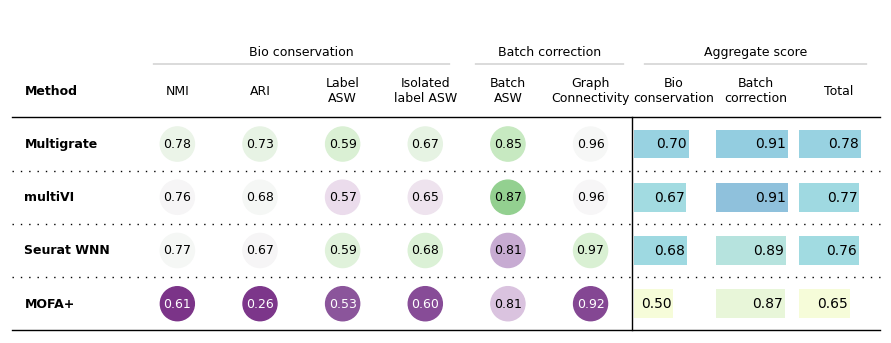

In [71]:
num_embeds = len(plot_df)

# Allow to manipulate text post-hoc (in illustrator)
with matplotlib.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 9, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col="Method",
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.savefig('figures/scib_table_neurips_multiome.svg', bbox_inches='tight')

plt.show()


# 10x

In [72]:
df_mofa = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/MOFA+/10x_mofa_new.csv', index_col=0, header=0)
df_mofa = df_mofa.dropna()
df_mofa = df_mofa.T
df_mofa = df_mofa.rename(index={'0': 'MOFA+'})
df_mofa

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
MOFA+,0.791609,0.718718,0.632117,0.953821,0.656029,0.992759


In [73]:
df_multigrate = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/multigrate/multigrate_10x_multiome.csv', index_col=0, header=0)
df_multigrate = df_multigrate.dropna()
df_multigrate = df_multigrate.T
df_multigrate = df_multigrate.rename(index={'0': 'Multigrate'})
df_multigrate

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.79917,0.744534,0.674276,0.950534,0.684324,0.987826


In [74]:
df_totalvi = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/code/recomb_multimodal_q2r/data/10x/0.001_embed.csv', index_col=0, header=0)
df_totalvi = df_totalvi.dropna()
df_totalvi = df_totalvi.T
df_totalvi = df_totalvi.rename(index={'0': 'multiVI'})
df_totalvi

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
multiVI,0.795632,0.72338,0.637931,0.966903,0.666971,0.968455


In [75]:
df_wnn = pd.read_csv('/lustre/groups/ml01/workspace/anastasia.litinetskaya/notebooks/multigrate_integration/Seuratv4/10x-seurat.csv', index_col=0, header=0)
df_wnn = df_wnn.dropna()
df_wnn = df_wnn.T
df_wnn = df_wnn.rename(index={'0': 'Seurat WNN'})
df_wnn

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Seurat WNN,0.81687,0.749073,0.605977,0.96876,0.639471,0.974883


In [76]:
df = pd.concat([df_multigrate, df_mofa, df_totalvi, df_wnn])
df

,NMI_cluster/label,ARI_cluster/label,ASW_label,ASW_label/batch,isolated_label_silhouette,graph_conn
Multigrate,0.799170,0.744534,0.674276,0.950534,0.684324,0.987826
MOFA+,0.791609,0.718718,0.632117,0.953821,0.656029,0.992759
multiVI,0.795632,0.723380,0.637931,0.966903,0.666971,0.968455
Seurat WNN,0.816870,0.749073,0.605977,0.968760,0.639471,0.974883


In [77]:
df = df.rename(columns={
    'NMI_cluster/label': 'NMI', 
    'ARI_cluster/label': 'ARI',
    'ASW_label': 'Label ASW',
    'ASW_label/batch': 'Batch ASW',
    'isolated_label_silhouette': 'Isolated label ASW',
    'graph_conn': 'Graph Connectivity',
})

In [78]:
df.loc[:, 'Bio conservation'] = np.mean([df.loc[:, 'ARI'], df.loc[:, 'NMI'], df.loc[:, 'Label ASW']], axis=0) # no Isolated label ASW as no batch
df

,NMI,ARI,Label ASW,Batch ASW,Isolated label ASW,Graph Connectivity,Bio conservation
Multigrate,0.799170,0.744534,0.674276,0.950534,0.684324,0.987826,0.739327
MOFA+,0.791609,0.718718,0.632117,0.953821,0.656029,0.992759,0.714148
multiVI,0.795632,0.723380,0.637931,0.966903,0.666971,0.968455,0.718981
Seurat WNN,0.816870,0.749073,0.605977,0.968760,0.639471,0.974883,0.723973


In [79]:
df.loc[:, 'Total'] = df.loc[:, 'Bio conservation']

In [80]:
df = pd.concat([df, df_type])

In [81]:
df = df.drop(['Graph Connectivity', 'Batch correction', 'Batch ASW', 'Isolated label ASW'], axis=1)
df

,NMI,ARI,Label ASW,Bio conservation,Total
Multigrate,0.79917,0.744534,0.674276,0.739327,0.739327
MOFA+,0.791609,0.718718,0.632117,0.714148,0.714148
multiVI,0.795632,0.72338,0.637931,0.718981,0.718981
Seurat WNN,0.81687,0.749073,0.605977,0.723973,0.723973
Metric Type,Bio conservation,Bio conservation,Bio conservation,Aggregate score,Aggregate score


In [82]:
score_cols = df.columns[df.loc['Metric Type'] == 'Aggregate score']
other_cols = df.columns[df.loc['Metric Type'] != 'Aggregate score']

In [83]:
plot_df = df.drop('Metric Type', axis=0)

In [84]:
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)

In [85]:
plot_df["Method"] = plot_df.index

In [86]:
column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

In [87]:
df

,NMI,ARI,Label ASW,Bio conservation,Total
Multigrate,0.79917,0.744534,0.674276,0.739327,0.739327
MOFA+,0.791609,0.718718,0.632117,0.714148,0.714148
multiVI,0.795632,0.72338,0.637931,0.718981,0.718981
Seurat WNN,0.81687,0.749073,0.605977,0.723973,0.723973
Metric Type,Bio conservation,Bio conservation,Bio conservation,Aggregate score,Aggregate score


In [88]:
plot_df.to_csv('csv/all_metrics_10x.csv')

In [89]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=df.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

In [90]:
cmap_fn = lambda col_data: normed_cmap(col_data, cmap=light_cmap, num_stds=2.5)

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": cmap_fn(plot_df[col]),
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=df.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

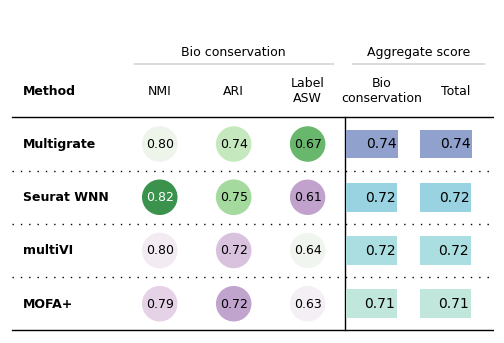

In [91]:
num_embeds = len(plot_df)

# Allow to manipulate text post-hoc (in illustrator)
with matplotlib.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(df.columns) * 1.25, 3 + 0.3 * num_embeds))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 9, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col="Method",
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.savefig('figures/scib_table_10x.svg', bbox_inches='tight')

plt.show()
